<a href="https://colab.research.google.com/github/vu21csen0300061/Malaria_detection/blob/main/malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-learn

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Input,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall

In [ ]:
dataset,info=tfds.load('malaria',with_info=True,as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete1FQVNG/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpd467eif_tfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [ ]:
for data in dataset[0].take(1):
  print(data)


(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [ ]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

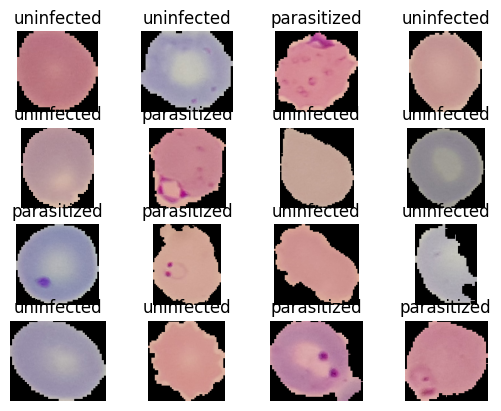

In [ ]:
for i, (image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)

  plt.imshow(image)
  plt.title(info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
a=train_dataset.take(1)
print(a)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
size=224
def resize_rescale(image,label):
  return tf.image.resize(image,(size,size))/255.0,label

In [ ]:
def augment(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  #image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  image = tf.image.flip_left_right(image)

  return image, label

In [ ]:
from tensorflow.keras.layers import RandomRotation,RandomFlip,RandomContrast,Resizing,Rescaling
augment_layers = tf.keras.Sequential([
       RandomRotation(factor = (0.25, 0.2501),),
       RandomFlip(mode='horizontal',),
       RandomContrast(factor=0.1),
       Resizing(224,224),
       Rescaling(1.0/255)

])


In [ ]:
#train_dataset=train_dataset.map(resize_rescale)
#val_dataset=val_dataset.map(resize_rescale)
test_dataset=test_dataset.map(resize_rescale)

In [ ]:
print(val_dataset)

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
train_dataset=(
    train_dataset
    .shuffle(buffer_size=8,reshuffle_each_iteration=True)
    .map(augment)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE))
val_dataset=(
    val_dataset
    .shuffle(buffer_size=8,reshuffle_each_iteration=True)
    .map(augment)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE))
#print(val_dataset)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
lenet_model=tf.keras.Sequential([
    InputLayer(input_shape=(size,size,3)),
    Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='relu'),
    MaxPool2D(pool_size=2,strides=2),
    Conv2D(filters=16,kernel_size=3,strides=1,padding='valid',activation='relu'),
    MaxPool2D(pool_size=2,strides=2),
    Flatten(),
    Dense(1000,activation='relu'),
    Dense(100,activation='relu'),
    Dense(1,activation='sigmoid'),
])
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense (Dense)               (None, 1000)              4

In [ ]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),loss=BinaryCrossentropy())

In [ ]:
history=lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=5,verbose=1)

Epoch 1/5
689/689 [==============================] - 1253s 2s/step - loss: 1.1231 - val_loss: 0.6933
Epoch 2/5
689/689 [==============================] - 1192s 2s/step - loss: 0.6934 - val_loss: 0.6934
Epoch 3/5
689/689 [==============================] - 1155s 2s/step - loss: 0.6934 - val_loss: 0.6935
Epoch 4/5
689/689 [==============================] - 1168s 2s/step - loss: 0.6934 - val_loss: 0.6934
Epoch 5/5
689/689 [==============================] - 1154s 2s/step - loss: 0.6934 - val_loss: 0.6935


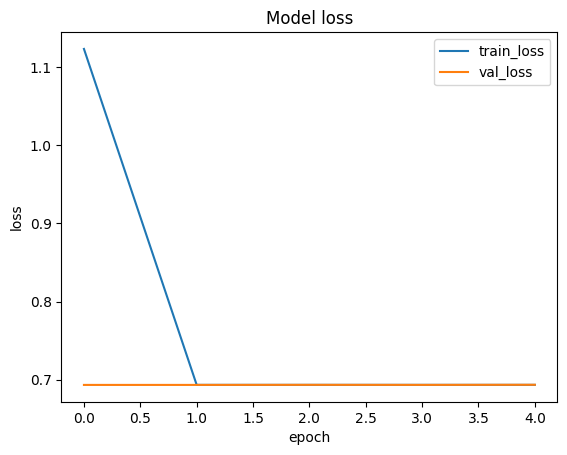

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 103s 33ms/step - loss: 0.6932


0.6931529641151428

In [ ]:
lenet_model.save("lenet")

In [ ]:
lenet_loaded_model = tf.keras.models.load_model("lenet")
lenet_loaded_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense (Dense)               (None, 1000)              4

In [ ]:
lenet_model.save("lenet.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
lenet_loaded_model = tf.keras.models.load_model("lenet.hdf5")
lenet_loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense (Dense)               (None, 1000)              4

In [ ]:
lenet_model.save_weights("weights/lenet_weights")

In [ ]:
lenet_weights_model = lenet_model.load_weights("weights/lenet_weights")

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')



Mounted at /content/drive/


In [ ]:
!cp -r /content/lenet/ /content/drive/MyDrive/lenet_colab/


!cp -r /content/drive/MyDrive/lenet_colab/ /content/lenet_colab/

functional api


In [ ]:
func_input = Input(shape = (224, 224, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D (pool_size = 2, strides= 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D (pool_size = 2, strides= 2)(x)

feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")
feature_extractor_model.summary()


Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)

callable


In [ ]:
func_input = Input(shape = (224, 224, 3), name = "Input Image")

x = feature_extractor_model(func_input)
x = Flatten()(x)

x= Dense(100,activation='relu')(x)
x = BatchNormalization()(x)
x= Dense(100,activation='relu')(x)
x = BatchNormalization()(x)
fuct_output= Dense(1,activation='sigmoid')(x)


lenet_funct_model = Model(func_input, fuct_output, name = "lenet_model")
lenet_funct_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense (Dense)               (None, 100)               4665700   
                                                                 
 batch_normalization_2 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               

model subclassing


In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()


In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

CUSTOM LAYERS


In [ ]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
    self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal", trainable = True)

  def call(self, input_features):

    pre_output = tf.matmul(input_features, self.w) + self.b

    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)

    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(pre_output)

    else:
      return pre_output

In [ ]:
IM_SIZE = 224
lenet_custom_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Flatten(),

                             NeuralearnDense(100, activation = "relu"),
                             BatchNormalization(),

                             NeuralearnDense(10, activation = "relu"),
                             BatchNormalization(),

                             NeuralearnDense(1, activation = "sigmoid"),

])
lenet_custom_model.summary()

In [ ]:

metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')]
lenet_funct_model.compile(optimizer = Adam(learning_rate = 0.01),
          loss = BinaryCrossentropy(),
          metrics = metrics)

In [ ]:
history=lenet_funct_model.fit(train_dataset,validation_data=val_dataset,epochs=10,verbose=1)

Epoch 1/10
689/689 [==============================] - 53s 66ms/step - loss: 0.3060 - tp: 9820.0000 - fp: 1520.0000 - tn: 9501.0000 - fn: 1205.0000 - accuracy: 0.8764 - precision: 0.8660 - recall: 0.8907 - val_loss: 0.2303 - val_tp: 1252.0000 - val_fp: 98.0000 - val_tn: 1268.0000 - val_fn: 137.0000 - val_accuracy: 0.9147 - val_precision: 0.9274 - val_recall: 0.9014
Epoch 2/10
689/689 [==============================] - 43s 63ms/step - loss: 0.2030 - tp: 10429.0000 - fp: 887.0000 - tn: 10136.0000 - fn: 594.0000 - accuracy: 0.9328 - precision: 0.9216 - recall: 0.9461 - val_loss: 0.3717 - val_tp: 1373.0000 - val_fp: 356.0000 - val_tn: 1011.0000 - val_fn: 15.0000 - val_accuracy: 0.8653 - val_precision: 0.7941 - val_recall: 0.9892
Epoch 3/10
689/689 [==============================] - 43s 63ms/step - loss: 0.1737 - tp: 10544.0000 - fp: 776.0000 - tn: 10248.0000 - fn: 478.0000 - accuracy: 0.9431 - precision: 0.9314 - recall: 0.9566 - val_loss: 1.2613 - val_tp: 108.0000 - val_fp: 19.0000 - val_t

In [ ]:
labels = []
inp = []

for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [ ]:
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)
#labels = np.array([i[0] for i in labels])
print(labels)


(2757, 224, 224, 3)
(2757, 224, 3)
[0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1

In [ ]:
predicted = lenet_funct_model.predict(np.array(inp))
print(predicted[:,0])


87/87 [==============================] - 1s 15ms/step
[0.00185313 1.         1.         ... 0.93309605 1.         1.        ]


[[1163  227]
 [  22 1345]]


Text(0.5, 58.7222222222222, 'Predicted')

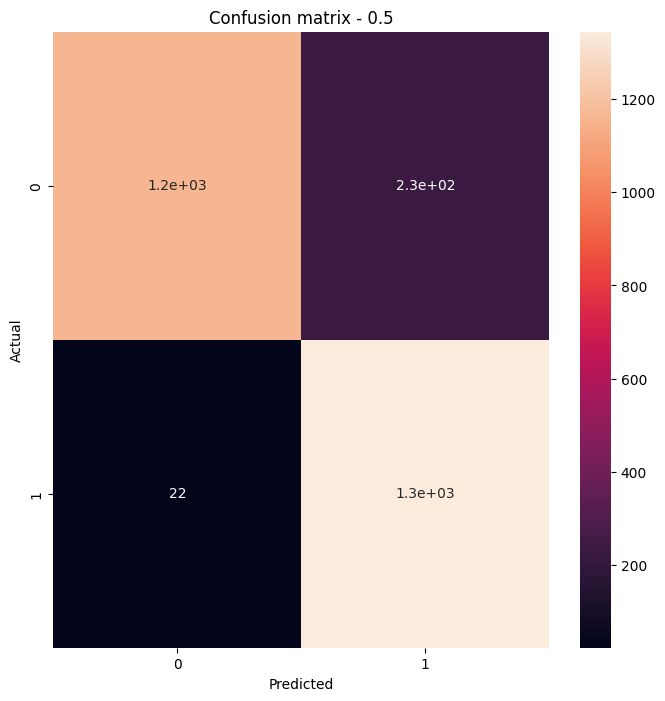

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

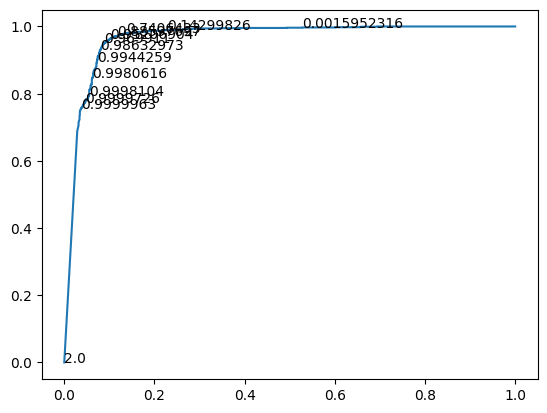

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])

plt.show()

In [ ]:
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)
history=lenet_funct_model.fit(train_dataset,validation_data=val_dataset,epochs=10,verbose=1,callbacks=[csv_callback,es_callback])

Epoch 1/10
689/689 [==============================] - 45s 66ms/step - loss: 0.0984 - tp: 10739.0000 - fp: 484.0000 - tn: 10539.0000 - fn: 284.0000 - accuracy: 0.9652 - precision: 0.9569 - recall: 0.9742 - val_loss: 0.3170 - val_tp: 1352.0000 - val_fp: 118.0000 - val_tn: 1240.0000 - val_fn: 45.0000 - val_accuracy: 0.9408 - val_precision: 0.9197 - val_recall: 0.9678
Epoch 2/10
689/689 [==============================] - 52s 75ms/step - loss: 0.0898 - tp: 10749.0000 - fp: 456.0000 - tn: 10565.0000 - fn: 276.0000 - accuracy: 0.9668 - precision: 0.9593 - recall: 0.9750 - val_loss: 0.2088 - val_tp: 1295.0000 - val_fp: 93.0000 - val_tn: 1266.0000 - val_fn: 101.0000 - val_accuracy: 0.9296 - val_precision: 0.9330 - val_recall: 0.9277
Epoch 3/10
689/689 [==============================] - 45s 65ms/step - loss: 0.0751 - tp: 10805.0000 - fp: 355.0000 - tn: 10668.0000 - fn: 218.0000 - accuracy: 0.9740 - precision: 0.9682 - recall: 0.9802 - val_loss: 0.2008 - val_tp: 1340.0000 - val_fp: 98.0000 - val_

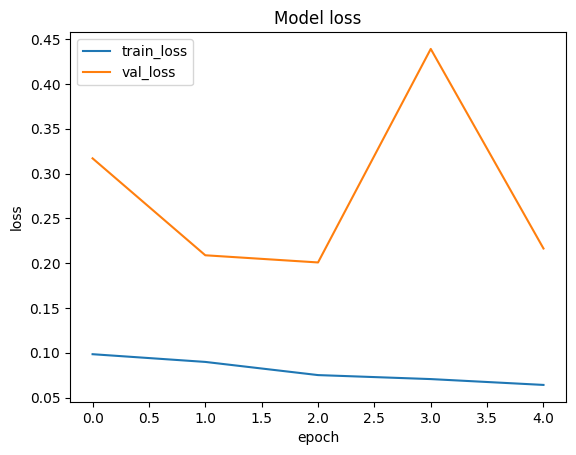

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

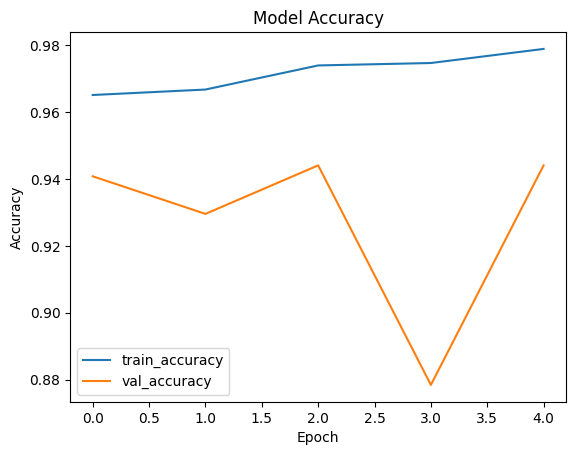

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()